# Apprentissage par renforcement

Importation des libraries utiles

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.pyplot as plt

from IPython import display
from IPython.display import clear_output
from time import sleep

%matplotlib inline

## L'environnement OpenAI Gym

Gym permet d'expérimenter des algorithmes de renforcement sur des environnements "standardisés"

Sous anaconda prompt :
pip install gym

In [2]:
!pip install gym

In [3]:
import gym

In [4]:
env = gym.make("Taxi-v3").env

**render()** permet de visulaiser l'environnement de départ

In [5]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



On simule un taxi autonome :
- Le taxi libre est coloré en jaune
- S'il a pris un client, il est représenté en vert
- La station où attend le client (points R, G, B ou Y) est coloré en bleu
- La station où se rend le client est magenta

<img src="https://storage.googleapis.com/lds-media/images/Reinforcement_Learning_Taxi_Env.width-1200.png">

Le taxi a six actions possibles :
- 0 : aller vers le sud (South)
- 1 : aller vers le nord (North)
- 2 : aller vers l'est (East)
- 3 : aller vers l'ouest (West)
- 4 : prendre le client (Pickup)
- 5 : déposer le client (Dropoff)
  
Si on exécute les actions au hasard, on peut déposer le passager à un endroit non désiré, ou tenter de prendre un client là où il n'est pas ... On va donc "pénaliser" ces cas, en leur affectant une "récompense" (*reward*) négative :
- reward = -10 si on tente de prendre ou déposer un client au mauvais endroit
- reward = -1 pour chaque action
- reward = +20 si on a déposé le client au bon endroit

Le code des environnements est disponible en open source. Par exemple, pour le taxi :  
https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py

In [6]:
print(env.action_space.n)

6


On a 500 états possibles : (25 cases du terrain)x(5 positions possibles du client, y compris le cas il est dans le taxi)x(4 destinations)

In [7]:
print(env.observation_space.n)

500


On peut choisir une action au hasard avec **env.action_space.sample()**

In [8]:
action = env.action_space.sample()
print(action)

1


**env.step(action)** exécute **action** dans l'environnement courant :

In [9]:
env.reset() # remet l'environnement dans l'état initial
env.render()
action = env.action_space.sample()
state,reward,done,info = env.step(action)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)


**env.step** renvoie 4 éléments :
- **state** : un objet représentant l'obervation par l'agent de l'environnement (une représentation de l'état courant)
- **reward** : la récompense résultant de l'action
- **done** : **True** si la simulation ou le jeu est terminé
- **info** : dictionnaire contenant des informations de diagnostic


In [10]:
print(state,reward,done,info)

352 -1 False {'prob': 1.0}


In [11]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)


In [12]:
env.s

352

On définit une fonction **policy** qui choisit une action au hasard :

In [13]:
def policy() :
    action = env.action_space.sample()
    return action

On exécute des actions au hasard jusqu'à ce que l'épisode soit terminé (**done == False**) :

In [14]:
def play_episode(state) :
    done = False
    env.s = state
    while not done :
        env.render()
        action = policy()
        _,_,done,_ = env.step(action)
    env.close()

In [15]:
state = env.reset()

In [16]:
episode = play_episode(state)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B

Cette suite d'actions jusqu'à la fin de la simulation est appelée un *épisode*

On a forcément fait de nombreuses erreurs, et le score final n'est pas bon ...

## Renforcement avec des tables : Q-learning

On va créer une table Q avec *n lignes* = nombre d'états et *n colonnes* = nombre d'actions :

In [17]:
Q = np.random.rand(env.observation_space.n, env.action_space.n)

In [18]:
print(Q)

[[0.54649623 0.92540367 0.84301773 0.07917708 0.569448   0.13352472]
 [0.56326268 0.49108176 0.93340304 0.97837144 0.55621316 0.13799624]
 [0.58954911 0.73253107 0.01734586 0.41258615 0.83208461 0.34259278]
 ...
 [0.80103946 0.52443732 0.41764406 0.94502654 0.43544269 0.51187831]
 [0.03218304 0.18342394 0.19757491 0.95479239 0.87509751 0.64532062]
 [0.34093657 0.83824818 0.18712859 0.27668846 0.60211008 0.92018316]]


On définit une politique qui choisit entre une action au hasard ou le max de la ligne correspondant à l'état courant dans la table Q, suivant un tirage aléatoire :

In [19]:
def policy(state) :
    epsilon = 0.5
    if random.uniform(0, 1) < epsilon :
        action = env.action_space.sample() # Choix aléatoire de la prochaine action
    else:
        action = np.argmax(Q[state]) # Choix de la meilleure action dans la table Q
    return action

On va appliquer la mise à jour de la table Q sur un épisode, suivant la formule :

$Q_{t+1}(s_{t},a_{t})=Q_{t}(s_{t},a_{t})+\alpha_{t}\cdot\left(R_{t+1}+\gamma \cdot max_a Q_{t}(s_{t+1},a) - Q_{t}(s_{t},a_{t}) \right)$

In [20]:
alpha = 0.3
gamma = 0.6

In [21]:
def play_episode(state) :
    global Q
    done = False
    env.s = state
    total_reward, nsteps = 0, 0
    while not done :
        action = policy(state)
        next_state,reward,done,_ = env.step(action)
        Q[state][action] = Q[state][action] + alpha*(reward + gamma * np.max(Q[next_state]) - Q[state][action])
        state = next_state
        total_reward += reward
        nsteps += 1
        if nsteps > 200 : break
    
    
    return total_reward, nsteps
    

In [22]:
nb_episodes = 1000

list_rewards = []
list_steps = []

for i in range(nb_episodes) :
    state = env.reset()
    total_reward, nsteps = play_episode(state)
    list_rewards.append(total_reward)
    list_steps.append(nsteps)
    print("Episode n° ",i)
    clear_output(wait=True)

print(total_reward, nsteps)

-21 24


Text(0.5, 0, 'Episode')

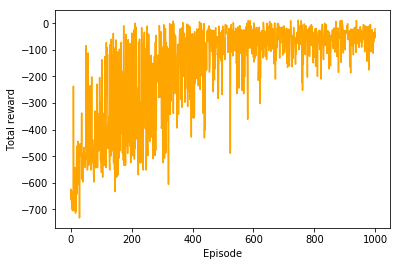

In [23]:
plt.plot(list_rewards, 'orange')
plt.ylabel('Total reward')
plt.xlabel('Episode')

Text(0.5, 0, 'Episode')

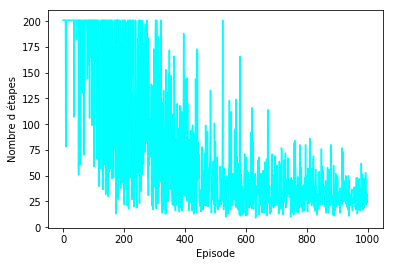

In [24]:
plt.plot(list_steps, 'cyan')
plt.ylabel('Nombre d étapes')
plt.xlabel('Episode')

In [25]:
print(Q)

[[  0.54649623   0.92540367   0.84301773   0.07917708   0.569448
    0.13352472]
 [ -2.41608872  -2.36080809  -2.40258706  -2.35989107  -2.26746077
  -11.35619626]
 [ -1.85436742  -1.4244299   -1.85560775  -1.42837374  -0.70428012
  -10.42350649]
 ...
 [ -1.52187701   0.28639613  -1.40925131  -1.30953995  -7.69855351
   -8.40707565]
 [ -2.16493936  -2.10076771  -2.15135297  -2.10631399  -8.7073665
   -9.56856397]
 [  5.72463946   2.36565542   3.86129277  11.29911782  -3.21057727
   -3.14507147]]


On va modifier la politique de choix avec un $\epsilon$ qui décroit avec l'apprentissage, de manière à ce qu'on choisisse plus souvent la table Q avec le temps :

In [26]:
def epsilon(n) :
    return 1/np.sqrt(1+float(n))

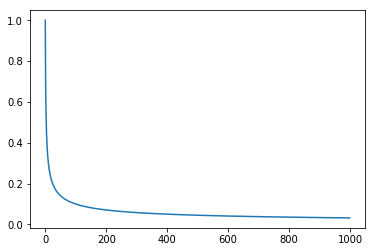

In [27]:
plt.plot([epsilon(n) for n in range(1000)])

Compléter la fonction pour prendre en compte l'$\epsilon$ variable (stratégie *$\epsilon$ -Greedy*)

In [28]:
def policy(state, n) :
    if random.uniform(0, 1) < epsilon(n):
        action = env.action_space.sample() # Choix aléatoire de la prochaine action
    else:
        action = np.argmax(Q[state]) # Choix de la meilleure action dans la table Q
    return action

In [29]:
Q = np.random.rand(env.observation_space.n, env.action_space.n)
def play_episode(state, episode_i) :
    done = False
    env.s = state
    total_reward, nsteps = 0, 0
    while not done :
        action = policy(state, episode_i)
        next_state,reward,done,_ = env.step(action)
        Q[state][action] = Q[state][action] + alpha*(reward + gamma * np.max(Q[next_state]) - Q[state][action])
        state = next_state
        total_reward += reward
        nsteps += 1
        if nsteps > 200 : break
    return total_reward, nsteps
    

Et on définit la fonction d'apprentissage sur **nb_episodes** :

In [30]:
def fit(nb_episodes) :
    list_rewards = [] # Liste des résultats
    list_steps = [] # Liste du nombre d'étapes par épisode
    for i in range(nb_episodes) :
        state = env.reset()
        total_reward, nsteps = play_episode(state,i)
        print("Episode n° ",i)
        clear_output(wait=True)
        list_rewards.append(total_reward)
        list_steps.append(nsteps) 
    
    return list_rewards, list_steps
    

In [31]:
Q = np.random.rand(env.observation_space.n, env.action_space.n)

alpha = 0.6
gamma = 0.9

list_rewards, list_steps = fit(1000)

Episode n°  999


On affiche l'évolution de la récompense totale avec le nombre d'étapes :

Text(0.5, 0, 'Episode')

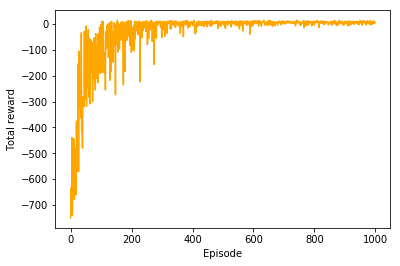

In [32]:
plt.plot(list_rewards, 'orange')
plt.ylabel('Total reward')
plt.xlabel('Episode')

et le nombre de steps par épisode :

Text(0.5, 0, 'Episode')

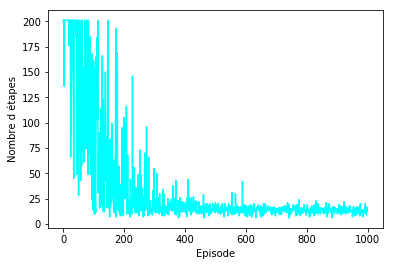

In [33]:
plt.plot(list_steps, 'cyan')
plt.ylabel('Nombre d étapes')
plt.xlabel('Episode')